# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [16]:
!nvidia-smi

Sat Nov 25 09:32:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0    49W / 250W |   1862MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [17]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
# !wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !pip install gdown --upgrade
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

In [18]:
# ! unzip food11.zip

# Import Packages

In [19]:
_exp_name = "sample"

In [20]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [21]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [22]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=(-90,90)),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [23]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None, num_class=11):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        # one_hot_label = torch.zeros(self.num_class)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])

        except:
            label = -1 # test has no label
            
        return im,label

# Model

In [24]:
# class Classifier(nn.Module): # use softmax
#     def __init__(self):
#         super(Classifier, self).__init__()
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         # torch.nn.MaxPool2d(kernel_size, stride, padding)
#         # input 維度 [3, 128, 128]
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

#             nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

#             nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

#             nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
#             nn.Conv2d(512, 1024, 3, 1, 1), # [512, 8, 8]
#             nn.BatchNorm2d(1024),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [1024, 4, 4]
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(1024*4*4, 1024*4),
#             nn.ReLU(),

#             nn.Linear(1024*4, 1024),
#             nn.ReLU(),

#             nn.Linear(1024, 512),
#             nn.ReLU(),

#             nn.Linear(512, 256),
#             nn.ReLU(),

#             nn.Linear(256,11),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         out = self.cnn(x)
#         # print(out.size())

#         out = out.view(out.size()[0], -1)
#         # print(out.size())
        
#         out = self.fc(out)
#         # print(out.size())
#         return out

from HW3 import Classifier

In [25]:
# test_X = torch.zeros(2,3,128,128)
# model = Classifier()
# test_y = model(test_X)

# test_y


# Configurations

In [26]:
# # "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# # Initialize a model, and put it on the device specified.
# model = Classifier().to(device)

# Initialize a model
model = Classifier()

# Check if multiple GPUs are available and if so, use them.
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    # print(f"Using {torch.cuda.device_count()} GPUs!")
    # model = nn.DataParallel(model)
    model = nn.DataParallel(model, device_ids=[0,3])

# Put the model on the device
model.to(device)

# The number of batch size.
batch_size = 32  * 4 * 2 * 2

# The number of training epochs.
n_epochs = 30

# If no improvement in 'patience' epochs, early stop.
patience = 5

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Dataloader

In [27]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Start Training

In [28]:
# # Initialize trackers, these are not parameters and should not be changed
# stale = 0
# best_acc = 0

# for epoch in range(n_epochs):

#     # ---------- Training ----------
#     # Make sure the model is in train mode before training.
#     model.train()

#     # These are used to record information in training.
#     train_loss = []
#     train_accs = []

#     for batch in tqdm(train_loader):

#         # A batch consists of image data and corresponding labels.
#         imgs, labels = batch
#         #imgs = imgs.half()
#         #print(imgs.shape,labels.shape)

#         # Forward the data. (Make sure data and model are on the same device.)
#         logits = model(imgs.to(device))

#         # Calculate the cross-entropy loss.
#         # We don't need to apply softmax before computing cross-entropy as it is done automatically.
#         loss = criterion(logits, labels.to(device))

#         # Gradients stored in the parameters in the previous step should be cleared out first.
#         optimizer.zero_grad()

#         # Compute the gradients for parameters.
#         loss.backward()

#         # Clip the gradient norms for stable training.
#         grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

#         # Update the parameters with computed gradients.
#         optimizer.step()

#         # Compute the accuracy for current batch.
#         acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

#         # Record the loss and accuracy.
#         train_loss.append(loss.item())
#         train_accs.append(acc)
        
#     train_loss = sum(train_loss) / len(train_loss)
#     train_acc = sum(train_accs) / len(train_accs)

#     # Print the information.
#     print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

#     # ---------- Validation ----------
#     # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
#     model.eval()

#     # These are used to record information in validation.
#     valid_loss = []
#     valid_accs = []

#     # Iterate the validation set by batches.
#     for batch in tqdm(valid_loader):

#         # A batch consists of image data and corresponding labels.
#         imgs, labels = batch
        
#         #imgs = imgs.half()

#         # We don't need gradient in validation.
#         # Using torch.no_grad() accelerates the forward process.
#         with torch.no_grad():
#             logits = model(imgs.to(device))

#         # We can still compute the loss (but not the gradient).
#         loss = criterion(logits, labels.to(device))

#         # Compute the accuracy for current batch.
#         acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

#         # Record the loss and accuracy.
#         valid_loss.append(loss.item())
#         valid_accs.append(acc)
#         #break

#     # The average loss and accuracy for entire validation set is the average of the recorded values.
#     valid_loss = sum(valid_loss) / len(valid_loss)
#     valid_acc = sum(valid_accs) / len(valid_accs)

#     # Print the information.
#     print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


#     # update logs
#     if valid_acc > best_acc:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
#     else:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


#     # save models
#     if valid_acc > best_acc:
#         print(f"Best model found at epoch {epoch}, saving model")
#         torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") 
#         # only save best to prevent output memory exceed error
#         best_acc = valid_acc
#         stale = 0
#     else:
#         stale += 1
#         if stale > patience:
#             print(f"No improvment {patience} consecutive epochs, early stopping")
#             break

# Dataloader for test

In [29]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [31]:
state_dict = torch.load(f"{_exp_name}_best.ckpt")
new_state_dict = {k.partition('module.')[2]: v for k, v in state_dict.items()} # 使用数据并行会导致所有键将会有一个额外的 'module.' 前缀

model_best = Classifier().to(device)
# model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.load_state_dict(new_state_dict)

model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

100%|██████████| 6/6 [00:35<00:00,  5.99s/it]


In [32]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
# train_tfm = transforms.Compose([
#     # Resize the image into a fixed shape (height = width = 128)
#     transforms.Resize((128, 128)),
#     # You can add some transforms here.
#     transforms.ToTensor(),
# ])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 


In [ ]:
# import torch
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import matplotlib.cm as cm
# import torch.nn as nn

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Load the trained model
# model = Classifier().to(device)
# state_dict = torch.load(f"{_exp_name}_best.ckpt")
# model.load_state_dict(state_dict)
# model.eval()

# print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:28<00:00,  1.97it/s]
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the lib

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

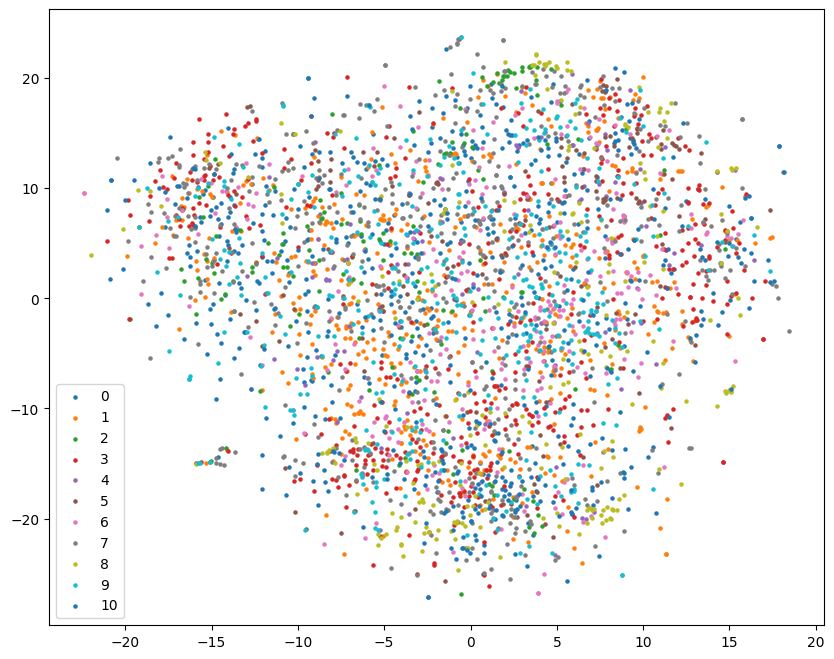

In [ ]:
# # Load the vaildation set defined by TA
# valid_set = FoodDataset("./valid", tfm=test_tfm)
# valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# # Extract the representations for the specific layer of model
# index =  5# You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
# features = []
# labels = []
# for batch in tqdm(valid_loader):
#     imgs, lbls = batch
#     with torch.no_grad():
#         logits = model.cnn[:index](imgs.to(device))
#         logits = logits.view(logits.size()[0], -1)
#     labels.extend(lbls.cpu().numpy())
#     logits = np.squeeze(logits.cpu().numpy())
#     features.extend(logits)
    
# features = np.array(features)
# colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# # Apply t-SNE to the features
# features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# # Plot the t-SNE visualization
# plt.figure(figsize=(10, 8))
# for label in np.unique(labels):
#     plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
# plt.legend()
# plt.show()

In [ ]:
# !pip freeze > requirement_2.txt